#### CIE4604 Simulation and Visualization
# Assignment 2 - GNSS-Reflectometry simulation

GPS and other GNSS satellite signals are reflected by the Earth’s oceans. A GNSS-R(eflectrometry) receiver on board a satellite in a low Earth orbit (LEO) is able to receive both the **direct** signal from a GNSS satellite, as well as the signal **reflected** by the surface of the Earth. This will provide very useful information on the Sea state and level in particular

![Remote Sensing geometry of GNSS-R (From: Jales, 2012](./dependencies/Jales2012.png)

For this assignment you are given the task to simulate a GNSS-R(eflectometry) experiment on board the International Space Station (ISS). 

All the Python scripts can be found in `CIE4604-M2-python` that you can download from Brightspace. For the assignment you need the following modules
- `tleplot.py`
- `crsutil.py`
- `specularpoint.py`

You will also need to have `simplekml` installed (See exercise 6). 

The `CIE4604-M2-python` download comes with 8 exercises in Jupyter notebooks. We suggest that you study the Jupyter notebooks first and do the exercises. These already contain a lot of useful material for the assignment, some of which can be re-purposed for the assignment. An other option is to do this assignment in parallel with the exercises.

## Description of the GNSS-R experiment on board the ISS

For the experiment a GNSS-R receiver will be installed on board the ISS. A GNSS-R receiver is able to

1.	Receive the direct signal from Global Navigation Satellite Systems (GNSS), such as the US GPS, Russian GLONASS, European GALILEO and Chinese BEIDOU satellites,
2.	Receive reflected GNSS signals from the Earth surface.

The path delay difference between direct and reflected signal is a measure for the Sea-surface height. However, by recording the full reflected wave form also other parameters about the sea state, such as wave-height and direction, can be retrieved.

The GNSS-R receiver on board the ISS uses two antenna’s, one **upward looking** standard **omnidirectional** antenna for the **direct** signals, and a specially designed **downward looking** antenna for the **reflected** signals. The opening angle of downward antenna (field of view) is not yet decided: the final value will depend on the outcome of the simulation, and will be a trade-off between received power and coverage.

## Breakdown in sub-tasks

The first step of any task is to break it down in more manageable sub-tasks. Normally this is something that you have to do yourself, but here, for this assignment, we will give you the task breakdown. The sub-tasks you have to perform are:

1. Simulate and visualize the ISS orbit trajectory
2. Simulate and visualize the GPS satellite orbits
3. Simulate and visualize GNSS signals from the upward looking omnidirectional antenna on the ISS (direct signals)
4. Simulate and visualize GNSS signals from the down looking antenna on the ISS (reflected signals)

More details on each sub-task can be found in the following cells.

## 1. Simulate and visualize the ISS orbit trajectory

Simulate and visualize the orbit trajectory of the International Space Station ISS. You may use Two-Line Elements (TLE) for ISS (Zarya) that you can find on Celestrak. The questions need to be answered in this sub-task:

a.	What are the main limitations of using GNSS-R from the ISS for the spatial and temporal coverage?
Hint: To answer this question you have to plot the ISS ground tracks (sub-satellite tracks), for which you may use `pltgroundtracks` from the `tleplot` Python module. 

b.	What is the effect of the opening angle (field of view) of the downward looking antenna on the spatial coverage? As part of your answer compute the area of coverage (on the Earth) for an opening angle (field of view) of 40 degrees and of 100 degrees. You may report the size of the area of coverage in degrees. Hint: Some background information is given in exercise 7 `CIE4604_M2_Exercise7_aoc.ipynb` notebook.

c.	Over how many hours or days do you have to carry out the simulation so that all areas, that can possibly be observed, are observed?  

In all steps we expect clear answers with a brief explanation. Include appropriate plots and visualizations wherever necessary.

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import crsutil as crs
import tleplot as tle
import specularpoint as sp
from scipy.io import loadmat
from scipy.integrate import quad

In [2]:
# Enter here your code to plot the ISS ground tracks (sub-satellite tracks) using 
# pltgroundtracks from the tleplot Python module.
#
# If you wish, you can add more cells.

tle_stations = tle.tleget('stations')
tleERS=tle.tleread('stations.txt', verbose=0)
isat, satnames = tle.tlefind(tleERS, 0) # Zarya is indexed at 0 in our TLE file
print('isat:',isat)
# tleERS

Saving TLE set to default name
TLEGET: Downloaded stations.txt from http://celestrak.com/NORAD/elements/
Saved TLE to stations.txt
Found 1 satellites:
 ISS (ZARYA)  (0)
isat: [0]


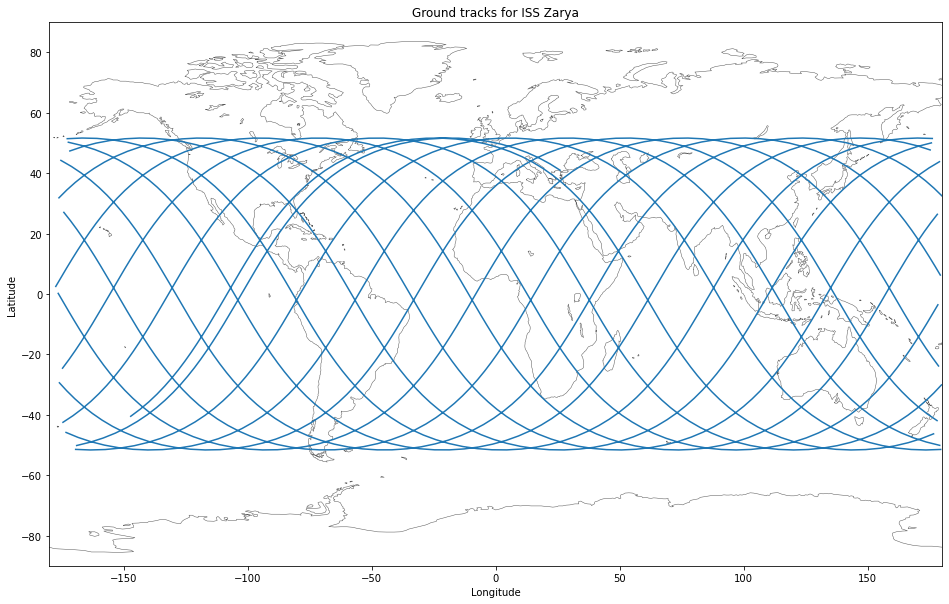

In [3]:
# 1.a plot ISS tracks


t = tle.tledatenum(['2021-11-29 18:39', 24*60, 1])

xsat_iss, vsat_iss = tle.tle2vec(tleERS, t, 0) # adapted from exercise 2

# the pltgroundtrack function takes the xsate in ECEF so convert to ECEF
xsate_iss, vsate_iss = crs.eci2ecef(t, xsat_iss, vsat_iss) # adapted from exercise 2

plt.figure(figsize=(16,10)) # adapted from example in help for this function
# pltgroundtrack((sat1, dsat), visible=visible, satid=satid)
plt.title("Ground tracks for ISS Zarya")
tle.pltgroundtrack(xsate_iss, satid="ISS")
# plt.legend() 
# plt.show()


### Answer 1.a
As is visible from the ground plot of ISS Zarya in the above cell, we can conclude that the usage of ISS Zarya would render us unable to use GNSS-R as it should be ideally. The ISS has an off set which is visible in this 24 hour ground plot, the offset is highly visible in the latitude range of $±40 \degree$ and longitudanal range of $-50 \degree$ to $-100 \degree$ .

Another disadvantage is clearly visible in terms of the coverage, the satellite fails to cover latitudes beyond $±50 \degree$ .


### Answer 1.b

In [4]:
def scircle1(lat0,lon0,theta):
    
    slat0 = np.sin(np.deg2rad(lat0))
    clat0 = np.cos(np.deg2rad(lat0))

    stheta = np.sin(np.deg2rad(theta))
    ctheta= np.cos(np.deg2rad(theta))
    
    alpha = np.deg2rad( np.arange(0,360,10) )
    
    lat = np.arctan2( slat0*ctheta + clat0*stheta*np.cos(alpha) ,
         np.sqrt( (clat0*ctheta - slat0*stheta*np.cos(alpha))**2 + (stheta *np.sin(alpha))**2 ))
    dlon = np.arctan2( stheta * np.sin(alpha) , clat0*ctheta - slat0*stheta*np.cos(alpha) )

    lat = np.rad2deg(lat)
    lon = lon0 + np.rad2deg(dlon)

    return lat, lon

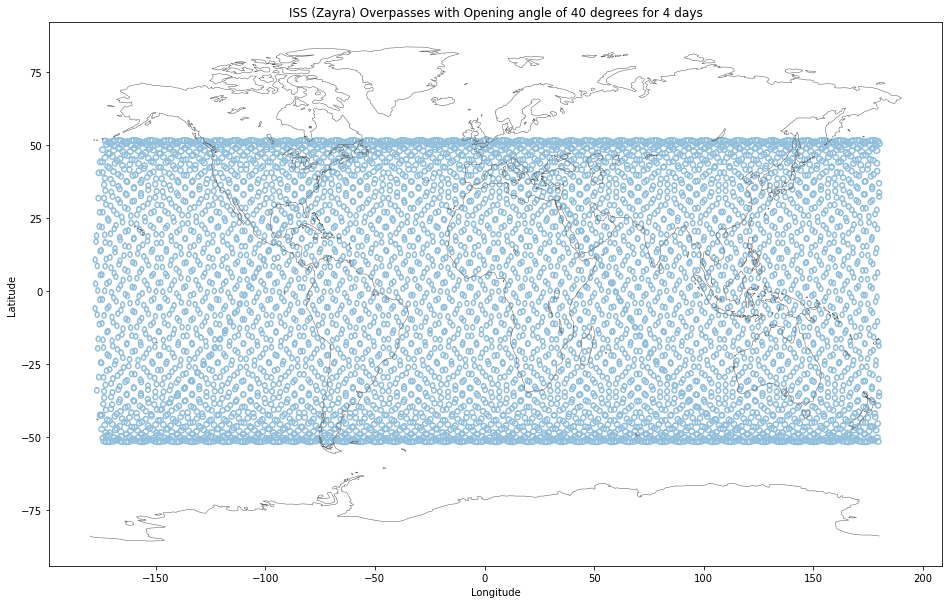

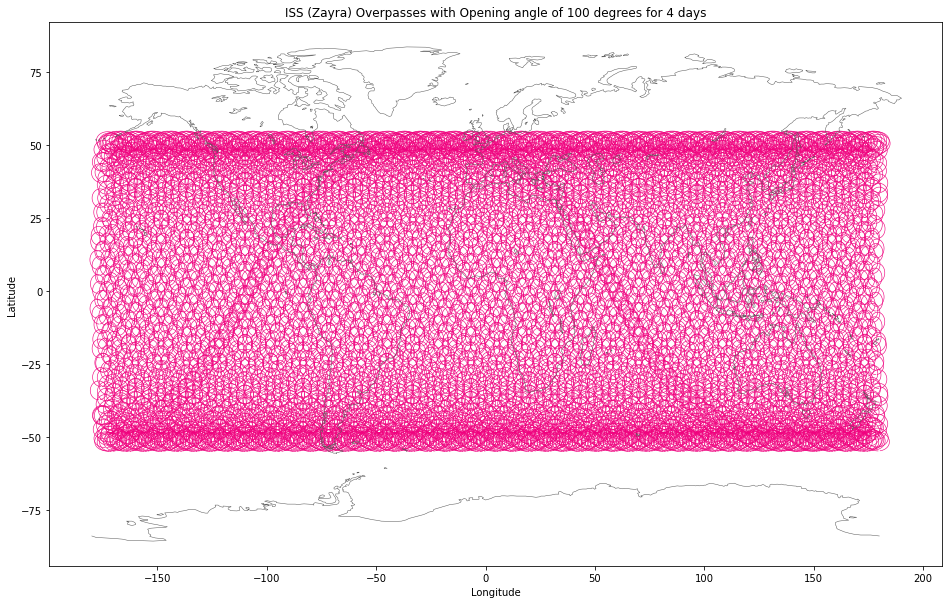

maxlat for 40 is: 52.54104476483311 and for 100 is 54.84126833816547


In [5]:
# 1.b
no_days = 4
t = tle.tledatenum(['2021-11-29 18:39', 24*60*no_days, 1])
xsat_iss, vsat_iss = tle.tle2vec(tleERS, t, 0) # adapted from exercise 2
xsate_iss, vsate_iss = crs.eci2ecef(t, xsat_iss, vsat_iss) # adapted from exercise 2


# from tleplot, line 1133,1134
lsat = np.arctan2(xsate_iss[:,1], xsate_iss[:,0]) * 180 / np.pi
dsat = np.arctan(xsate_iss[:,2] / np.sqrt(xsate_iss[:,1]**2 + xsate_iss[:,0]**2) )  * 180 / np.pi


# masking from tleplot.py lines 1140 to 1143
lsatmask, dsatmask = np.ma.array(lsat), np.ma.array(dsat)

lsatmask[np.hstack([False,np.abs(np.diff(lsat)) > 180])] = np.ma.masked 
dsatmask[np.hstack([False,np.abs(np.diff(dsat)) > 90])] = np.ma.masked 

Re = 6378136 # radius of earth in metres

r = np.sqrt(np.sum(xsate_iss**2, axis=1)) # satetlite radius 

# initialize empty arrays
theta_40, theta_100 = np.zeros_like(lsatmask), np.zeros_like(lsatmask)

# off-nadir angles converted to radians using np
n_40 = np.deg2rad(40)/2
n_100 = np.deg2rad(100)/2

# theta for each position, from exercise 7: theta = np.rad2deg( np.arcsin( r/Re * np.sin(np.deg2rad(eta)) )) - eta
# note that the theta obtained finally are in degrees
theta_40 =  np.rad2deg(np.arcsin( (r/Re) * np.sin(n_40 ) - n_40  ))
theta_100 = np.rad2deg(np.arcsin( (r/Re) * np.sin(n_100) - n_100 ))


# ///////////// PLOT FOR 40 deg Opening
# for 40 deg
plt.figure(figsize=(16,10))

maxlat_40=-3000
for lat,lon,theta in zip(dsatmask, lsatmask,theta_40):   
    lat_sCirc, lon_sCirc = scircle1(lat,lon,theta)
    if max(lat_sCirc) > maxlat_40: maxlat_40 = max(lat_sCirc)
    plt.plot(lon_sCirc, lat_sCirc, color='#91bfdb',)
    
plt.title(f'ISS (Zayra) Overpasses with Opening angle of 40 degrees for {no_days} days')

coast = loadmat("coast.mat")
plt.plot(coast["long"], coast["lat"], color=(0.35, 0.35, 0.35), linewidth=0.5)

plt.xlabel("Longitude");
plt.ylabel("Latitude");
plt.show();

# ///////////// PLOT FOR 100 deg Opening
# for 100 deg
plt.figure(figsize=(16,10))

maxlat_100=-3000
for lat,lon,theta in zip(dsatmask, lsatmask,theta_100):   
    lat_sCirc, lon_sCirc = scircle1(lat,lon,theta)
    if max(lat_sCirc) > maxlat_100: maxlat_100 = max(lat_sCirc)
    plt.plot(lon_sCirc, lat_sCirc, color='#f0027f', linewidth=0.6)
    
plt.title(f'ISS (Zayra) Overpasses with Opening angle of 100 degrees for {no_days} days')

coast = loadmat("coast.mat")
plt.plot(coast["long"], coast["lat"], color=(0.35, 0.35, 0.35), linewidth=0.5)

plt.xlabel("Longitude");
plt.ylabel("Latitude");
plt.show();


print(f'maxlat for 40 is: {maxlat_40} and for 100 is {maxlat_100}')

we see that upon increase of the look angle from 40 degrees to 100 degrees, the area of coverage increases

## 2. Simulate and visualize the GPS satellite orbits

Simulate and visualize the GPS orbits. You may again use TLE from Celestrak. Deliverables for this sub-task are:

a.	Plot of the GPS ground tracks.  You may again use `pltgroundtracks` from the `tleplot` module. Please think carefully about how to plot this data in a nice and concise manner, as there are about 30 operational GPS satellites.

b.	Polar plot (skyplot), using the azimuth and zenith angles, for a station on the Earth (e.g. Delft).  Hint: You may use the function `skyplot` from the `tleplot`  module. 

c.	Plot with the number of GPS satellite in view as function of time for the same ground station. Consider carefully how you define visibility and which value you use as elevation cut-off angle. Hint: As an intermediate step, create a 2D boolean array with an axis for satellite, and an axis for time, with True whenever a satellite is visible.

You may use a period of one day for these plots.

Saving TLE set to default name
TLEGET: Downloaded gps-ops.txt from http://celestrak.com/NORAD/elements/
Saved TLE to GPS.txt


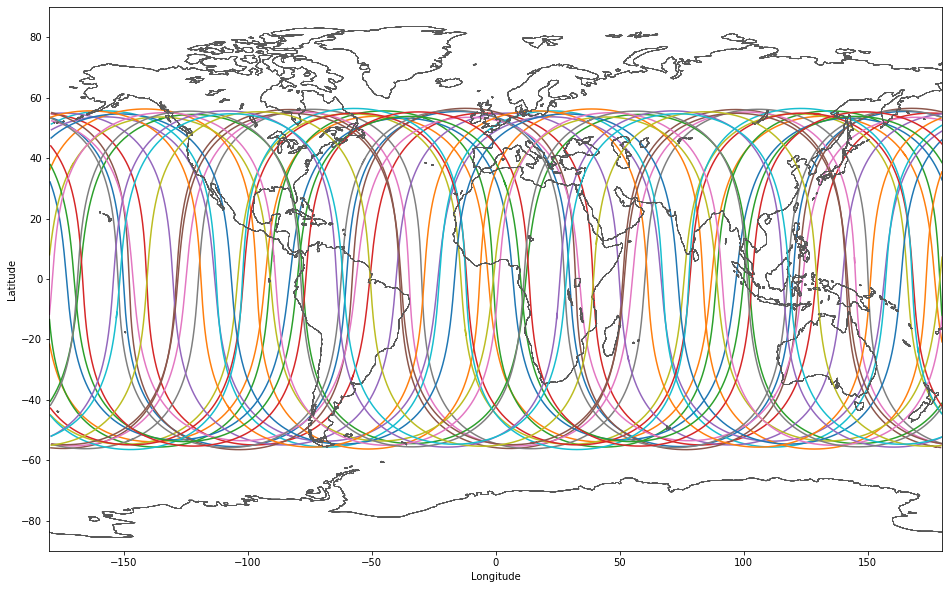

In [8]:
# enter here your code and run the cell to produce the result, if you wish you can use more cells

gpsERS = tle.tleread(tle.tleget('GPS'),verbose=0)

plt.figure(figsize=(16,10))

for satellite in gpsERS:
    t = tle.tledatenum(['2021-11-23 0:00:00', 24*60 ,1])
    xsat_gps,vsat_gps = tle.tle2vec(gpsERS,t,satellite.name)
    xsate_gps,vsate_gps = crs.eci2ecef(t,xsat=xsat_gps,vsat=vsat_gps)
    # kwargs={'linewidth':0.4}
    tle.pltgroundtrack(xsate_gps)

plt.show()



### Answer 2.b

Taking a 15 degree elevation cutoff for delft, the plot below depics the skyplot for visible GPS satellites

Delft ecef coordinate:  [10332497.84373162  8069310.22667264  5367016.3811587 ]
(3,)


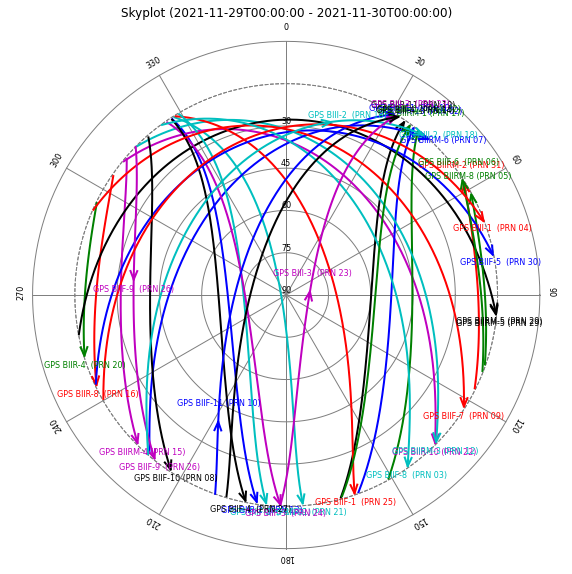

In [9]:
# to create a polar plot we need to define a location and find the look angles there
# we define a time array for this problem
t = tle.tledatenum(['2021-11-29 0:00:00', 1*24*60, 1])

# delft lat lon in radians
delft_lat_rad = np.deg2rad(4.358)
delft_lon_rad = np.deg2rad(52.01144)

# convert lat/long to ecef location
delft_ecef = Re*np.array(
    [
        np.cos(delft_lat_rad)/np.cos(delft_lon_rad),  # x value
        np.cos(delft_lat_rad)/np.sin(delft_lon_rad),  # y value
        np.sin(1),  # z value
    ]
)
# print the delft coorindates to check them
print('Delft ecef coordinate: ', delft_ecef)
print(delft_ecef.shape)

# # set up a function to get the look angles from delft


# def lookangle_from_delft(t, sat_data_ecef):
#     lookangle, flags = crs.satlookanglesp(t, sat_data_ecef, delft_ecef)
#     return lookangle


plt.figure(figsize=(10, 10))
names = []

az_array = np.zeros((len(t), len(gpsERS)))
zen_array = np.zeros((len(t), len(gpsERS)))

for i, sat in enumerate(gpsERS):

    xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
    xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
    combined = np.concatenate((xsate, vsate), axis=1)
    las_array, flags = crs.satlookanglesp(t, combined, delft_ecef)
    zen = las_array[:, 0]
    azi = las_array[:, 1]

    az_array[:, i] = azi
    zen_array[:, i] = zen
    names.append(sat.name)


tle.skyplot(t, az_array, zen_array, satnames=names, cutoff=15)




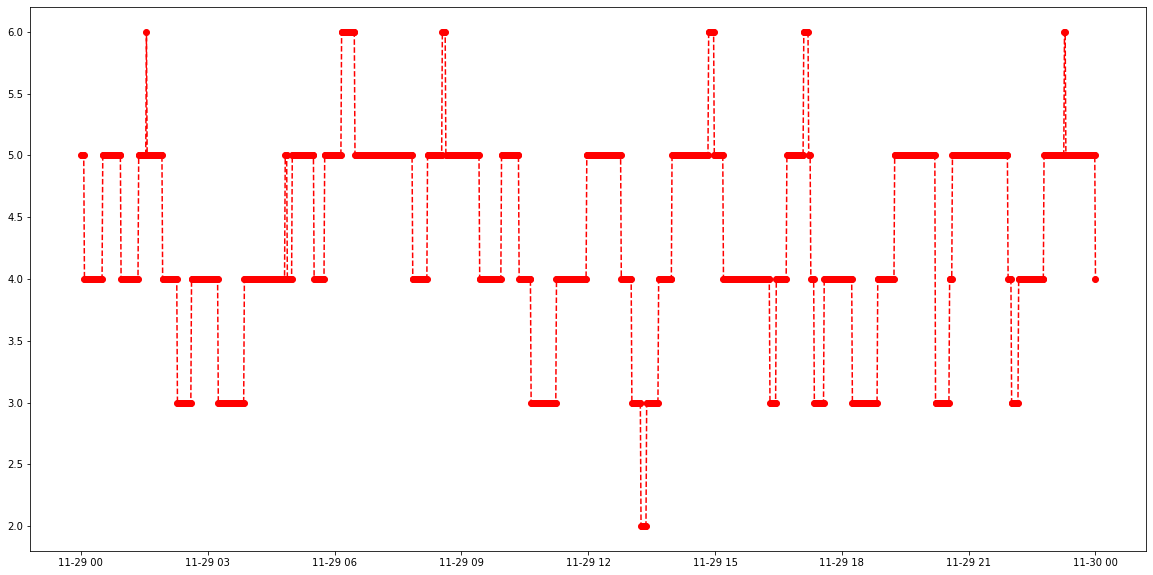

In [10]:
# 2.c

elevation = np.pi/2 - zen_array

cutoff = 15    # cutoff angle in degrees
visible_delft = elevation > np.radians(cutoff)

visibility_with_time = np.sum(visible_delft, axis=1)

plt.figure(figsize=(20,10))
plt.plot_date(t , visibility_with_time, fmt='ro--')
plt.show();

# plt.plot_date?

*Enter here your answers using markdown. Use one cell for each subquestion.*

## 3. Simulate and visualize direct signals

Simulate and visualize GNSS signals from the **upward looking omnidirectional** antenna on the ISS (direct signals). The opening angle of the upward looking antenna is 160 degrees (comparable to a 10 degree elevation cut-off angle). For this sub-task you have to use the simulated ISS and GPS positions from the previous sub-tasks. Questions to answer are:

a.	How many GPS satellites are on average in view from the upward looking antenna? Illustrate this by a plot with the number of GPS satellite in view as function of time from the ISS (as in 2c). How does this compare to a station on the Earth (e.g. Delft)?



You may use a period of one day for the plots. 

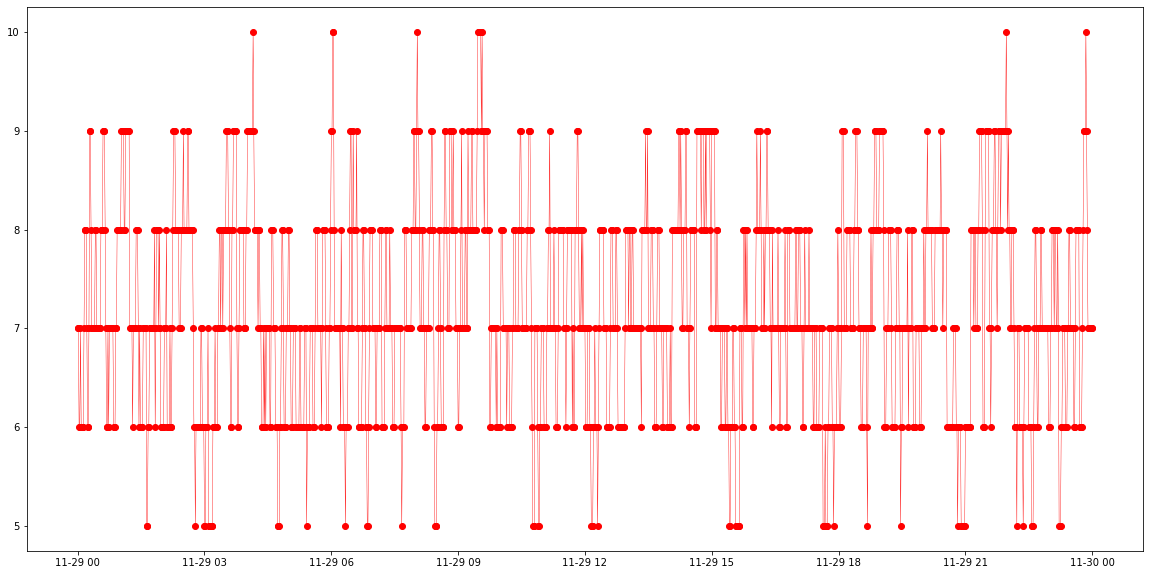

Average number of visible satellites from ISS: 7.176960444136017


In [11]:
# 3.a

# enter here your code and run the cell to produce the result, if you wish you can use more cells
no_days = 1
t = tle.tledatenum(['2021-11-29 00:00', 24*60*no_days, 1])
xsat_iss, vsat_iss = tle.tle2vec(tleERS, t, 0) # adapted from exercise 2
xsate_iss, vsate_iss = crs.eci2ecef(t, xsat_iss, vsat_iss) # adapted from exercise 2

# seems like 2 for loops, one for running at different 
# lat lon position of the ISS and another for the GPS satellites

names = []

az_array = np.zeros((len(t), len(gpsERS)))
zen_array = np.zeros((len(t), len(gpsERS)))


for i, sat in enumerate(gpsERS):
    # timeStamp = t[i_time:i_time+1]
    # print(timeStamp)
    xsat_gps, vsat_gps = tle.tle2vec(gpsERS, t , sat.name)
    xsate_gps, vsate_gps = crs.eci2ecef(t, xsat=xsat_gps, vsat=vsat_gps)
    combined = np.concatenate((xsate_gps, vsate_gps), axis=1)
    las_array, flags = crs.satlookanglesp(t, combined, np.concatenate((xsate_iss, vsate_iss), axis=1))
    zen = las_array[:, 0]
    azi = las_array[:, 1]

    az_array[:, i] = azi
    zen_array[:, i] = zen

    # print(zen_array.shape)
    names.append(sat.name)


elevation = np.pi/2 - zen_array

cutoff = 15    # cutoff angle in degrees
visible_iss = elevation > np.radians(cutoff)

visibility_with_time = np.sum(visible_iss, axis=1)

plt.figure(figsize=(20,10))
plt.plot_date(t , visibility_with_time, fmt='ro-', linewidth=0.4)
plt.show();

print(f"Average number of visible satellites from ISS: {np.average(visibility_with_time)}")


as compared to the station on earth, we observe that a higher number of maximum visible satellites is seen. While it was a maximum of 6 in Delft, the values from ISS are reaching maximum of 10 satellites.

b.	What is the average duration of GPS satellite visibility, in minutes from start to end for each pass, from the ISS? Include a plot that clearly illustrates this answer. Again, how does this compare to the a station on the Earth?

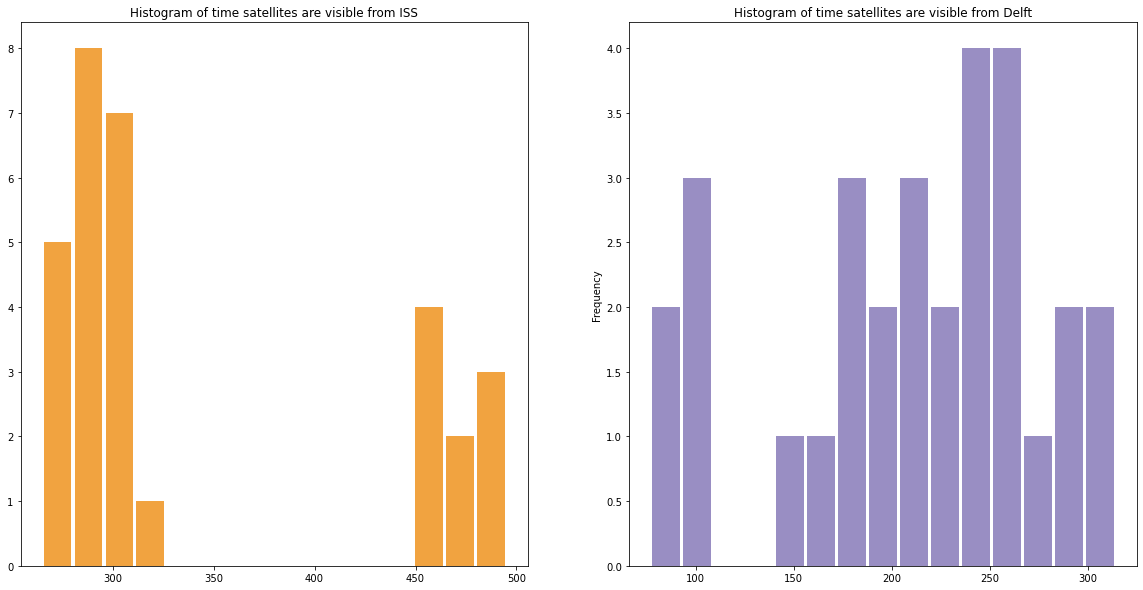

In [12]:
# 3.b
# visible[:,0].where(True)
# count the amount of time per satellite
time_of_visibility_iss= []
for i in range(visible_iss.shape[1]):
    time_of_visibility_iss.append(len(np.where(visible_iss[:,i]==True)[0]))

time_of_visibility_delft= []
for i in range(visible_delft.shape[1]):
    time_of_visibility_delft.append(len(np.where(visible_delft[:,i]==True)[0]))

fig, ax = plt.subplots(1,2, figsize=(20,10) )
ax[0].hist(time_of_visibility_iss, bins=15, rwidth=0.9  , color='#f1a340');
ax[0].set_title("Histogram of time satellites are visible from ISS")
ax[1].hist(time_of_visibility_delft, bins=15, rwidth=0.9, color='#998ec3');
ax[1].set_title("Histogram of time satellites are visible from Delft")
plt.ylabel("Frequency")
plt.show()

# names

On plotting a histogram of the amount of time that the PGS satellites are visible from both delft and the iSS, we see that the amount of time increases significantly for ISS with some values reaching 400-500 seconds.

c.	Visualize the ISS, GPS and observations from the upward looking omnidirectional antenna in Google Earth using the `simplekml` Python module. You may get some inspiration from exercise 6 `CIE4604-M2-Example6_kml.ipynb` notebook. Make separate kml folders (within the same kmz file) for ISS, GPS and direct observations. For the report (Jupyter notebook), include a screenshot showing trajectories for one day, but the direct observations only for a single epoch.

In [13]:
def xyz2coords(x):
    """Compute list of (longitude, latitude, height) tuples from Cartesian coordinates.
    """
    lat, lon, height = xyz2llh(x)
    coords = llh2coords(lat, lon, height)
    
    return coords

def xyz2llh(x):
    """Compute latitude, longitude and height from Cartesian coordinates.

    lat, lon, height = xyz2llh(x) computes the spherical latitude [deg], longitude [deg],
    and height [m] from the array Cartesian coordinates X,Y,Z in x [m]. The cartesian 
    coordinates are given in an 2D numpy array x with X, Y and Z in the respective columns.
    """

    Re = 6378136

    R = np.sqrt(np.sum(x**2, axis=1))

    lat = np.arcsin(x[:,2]/R) * 180/np.pi
    lon = np.arctan2(x[:,1], x[:,0]) * 180/np.pi
    height = R-Re
    
    return lat, lon, height

def llh2coords(lat, lon, height):

    if type(lat) in [int, float]:
        lat = [lat]
        lon = [lon]
        height= [height]
        
    coords = []
    for k in range(len(lon)):
         coords.append((lon[k], lat[k], height[k]))
    
    return coords


In [14]:
import simplekml
kml = simplekml.Kml()

coords_iss = xyz2coords(xsate_iss) 
# print(coords)

# ISS track
fol = kml.newfolder(name='ISS Track')
sat_iss = fol.newlinestring(name="ISS_Tracks", description="satellite track for assignment 2 question 3", coords=coords_iss)
sat_iss.altitudemode = simplekml.AltitudeMode.absolute
sat_iss.style.linestyle.color = simplekml.Color.red

GPSfol = kml.newfolder(name='GPS Tracks')


# GPS satellite tracks
for i, sat in enumerate(gpsERS):

    xsat_gps, vsat_gps = tle.tle2vec(gpsERS, t, sat.name)
    xsate_gps, vsate_gps = crs.eci2ecef(t, xsat=xsat_gps, vsat=vsat_gps)
    coords_gps = xyz2coords(xsate_gps) 
    sub = GPSfol.newlinestring(name=sat.name, description="GPS satellite (ground) track", coords=coords_gps)
    sub.altitudemode = simplekml.AltitudeMode.absolute
    sub.style.linestyle.color = simplekml.Color.blue

# single epoch direct observations
single_epoch = tle.tledatenum(['2021-11-29 12:00'])
iss_epoxh_x,iss_epoxh_v = tle.tle2vec(tleERS, single_epoch, 0)
xsate_iss_epoch, vsate_gps_iss_epoch = crs.eci2ecef(single_epoch, xsat=iss_epoxh_x, vsat=iss_epoxh_v)

directObs_fol = kml.newfolder(name='Direct Observations')


for sat in gpsERS:
    xsat_gps, vsat_gps = tle.tle2vec(gpsERS, single_epoch, sat.name)
    xsate_gps, vsate_gps = crs.eci2ecef(single_epoch, xsat=xsat_gps, vsat=vsat_gps)

    # add them together for use in satlookangesp function
    combined_gps = np.concatenate((xsate_gps,vsate_gps) , axis=1)
    lookangle,flags = crs.satlookanglesp(single_epoch, xsat=combined_gps, xobj=xsate_iss_epoch, swathdef=['VIS', 0, 80, ''])    

    if flags[0][2]=='VIS':
        ISS_to_sat = np.concatenate((xsate_iss_epoch, xsate_gps), axis=0)
        lineOfSightCoord = xyz2coords(ISS_to_sat)
        directView = directObs_fol.newlinestring(name=sat.name,description="Direct Observation lines", coords=lineOfSightCoord)
        directView.style.linestyle.color = simplekml.Color.orange
        directView.altitudemode = simplekml.AltitudeMode.absolute

kml.savekmz("A2.kmz") 


The KMZ file when opened in Google Earth Pro looks like the following: ![This photo](A2_Qn3.jpg) with the blue lines depicting the GPS satellite tracks, the red lines indicating the track of ISS Zarya, and the orange lines are the direct observations from ISS upward-looking antenna for a single epoch.

## 4. Simulate and visualize reflected signals


Simulate and visualize GNSS signals from the **downward looking** antenna on the ISS (reflected signals). The opening angle of the downward looking antenna is 40 degrees or 100 degrees.

a.	Make a function to compute the position of  the specular reflection points that are within the field of view (opening angle) of the down looking GPS antenna on board the ISS at a specified moment in time. 

Input for this function is:  the position of the ISS and  GPS satellite positions at a specific time (one epoch only), and the opening angle of the downward looking antenna (40 or 100 degrees). The output should be the position of the specular reflection points (zero, one or more) that fall within the opening angle. For the actual computation you may call the function `specularpoint` from the `specularpoint.py` module that is part of the `CIE4604_M2_Python.zip` distribution. This is also explained in more detail in exercise 8 `CIE4604_M2_Example8_sp.ipynb` notebook.

b.	Make a plot with the specular reflection points, ISS and GPS ground tracks in Python for a period of several minutes for two different values of the opening angle.

c.	Visualize the specular reflection points and reflected signals in Google Earth for two different values of the opening angle (40 degrees and 100 degrees), and add this to the kmz file of question 3c. Make a new kml folder (within the same kmz file) for each opening angle. 

Include in your report a screenshot of Google Earth showing the ISS, GPS and specular reflection point trajectories for a period of several minutes, while showing the direct and reflected signals only for a single epoch.

In [15]:

# steps:
# select visible satellite at given time from upward looking antenna
# find coord of specular reflections
# check if these points are visible in downward antenna 
# ( is the nadir angle to the specular point less than half the field of view)

# 4.a
def get_iss_ecef(t):
    """ 
    takes a time input , could be tle.datetime
    
    returns: (tuple) of xsate and vsate of ISS
    """
    xsat_iss,vsat_iss = tle.tle2vec(tleERS,t,'ISS (ZA')
    xsate_iss,vsate_iss = crs.eci2ecef(t,xsat=xsat_iss,vsat=vsat_iss)
    return  xsate_iss,vsate_iss


# gpssatxe, issxe,

def func_q3_spec(time_array, gpsERS , openingAngle=40):
    """
    summary: function takes array of time (tle.datetime), the GPS TLE file, and opening angle of receiving satellite
    return: list of points which are in
    """
    all_pts = []
    for t in time_array:
        # convert t to a valid date number
        a = crs.num2datetime(t)
        t = tle.tledatenum(a.isoformat())  
        xsate_iss,iss_vvalse = get_iss_ecef(t)
        satpos = np.zeros((len(gpsERS), 6))

        for i, sat in enumerate(gpsERS):
            xsat, vsat = tle.tle2vec(gpsERS, t, sat.name)
            xsate, vsate = crs.eci2ecef(t, xsat=xsat, vsat=vsat)
            satpos[i] = np.concatenate((xsate, vsate), axis=1) 
        
        validated_spec_pts_list = []
        # loop over the satellites 
        for sat in satpos:
            # calculate the look angles array and the flags. We only need to use the flags
            sat1 = (sat[:, None].T)
            # extract the visibility flags
            _ , flags = crs.satlookanglesp(t, xsat=sat1, xobj=xsate_iss, swathdef=['VIS', 0, 80, ''])
            # check the 'VIS' parameter, if it is there,
            if flags[0][2] == 'VIS':
                t_satCoord = sat1[0][:3]
                xp = sp.specularpoint(xsate_iss[0], t_satCoord)
                zrp, arp, _ = sp.xyz2zas(xsate_iss[0], xp)
                nadir2Pt = 180-zrp*180/np.pi
                # check the nadier is within the range
                # print(nadir_to_pt)
                if nadir2Pt < openingAngle/2:
                    # add specular point to list
                    validated_spec_pts_list.append(xp)
                    # print(nadir2Pt)
        pts= validated_spec_pts_list
        for pt in pts:
            all_pts.append(pt)

    return all_pts




### answer 4.b

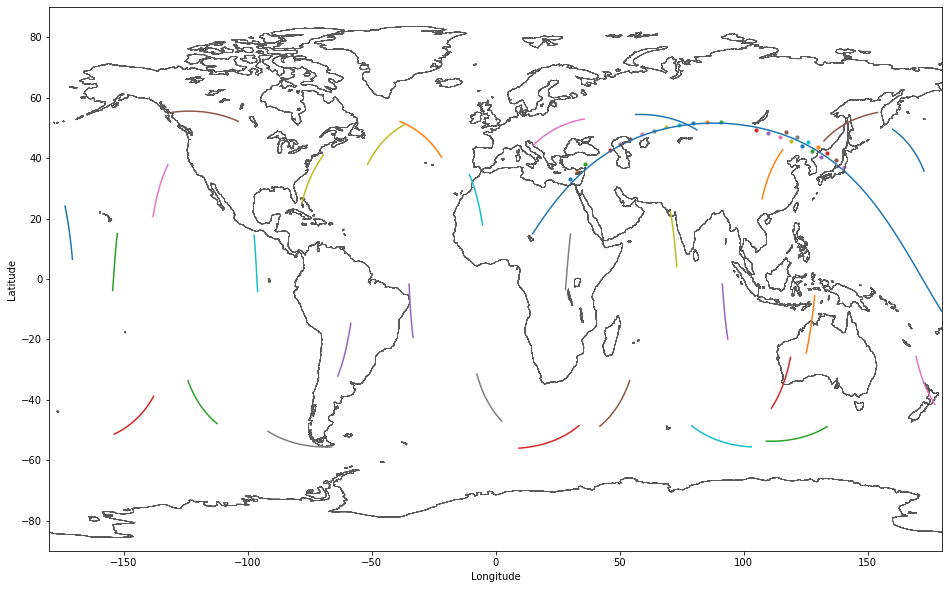

In [42]:
# opening angle of 40 for 45 min

# define a time window for this problem 
timeFrame = tle.tledatenum(['2021-11-28 12:00:00', 45 ,1])
# fine the specular points
specPts = func_q3_spec(timeFrame , gpsERS, 40)


# create a new figure
plt.figure(figsize=(16,10))
# get the ISS location during the problem time window
iss_ecef_x,iss_ecef_v = get_iss_ecef(timeFrame)

tle.pltgroundtrack(iss_ecef_x) # add the iss

# convert spec points to polar coord and plot
for point in specPts:
    stacked = np.vstack((point,point))
    tle.pltgroundtrack(stacked)

    sphere_spec = sp.cart2sphere(point)
    plt.scatter(sphere_spec[1],sphere_spec[0],s=10)
    
# add the GPS satellites
for i, sat in enumerate(gpsERS):
    xsat_gps, vsat_gps = tle.tle2vec(gpsERS, timeFrame, sat.name)
    xsate_gps, vsate_gps = crs.eci2ecef(timeFrame, xsat=xsat_gps, vsat=vsat_gps)
    tle.pltgroundtrack(xsate_gps , satid=sat.name)


kml_40 = [list(i) for i in specPts]
fol_40 = kml.newfolder(name='40 degree spec')



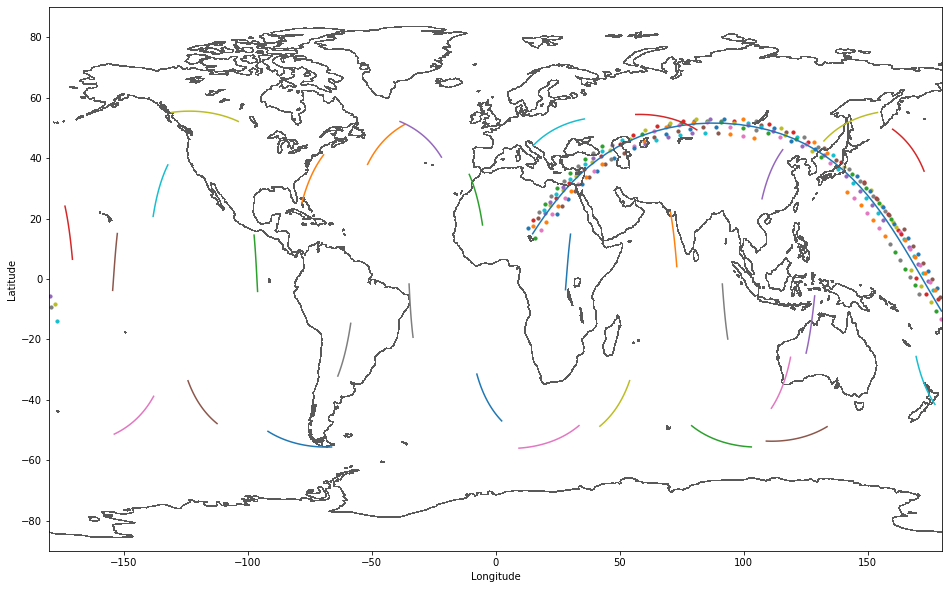

In [17]:
# opening angle of 100 for 45 min



# define a time window for this problem 
timeFrame = tle.tledatenum(['2021-11-28 12:00:00', 45 ,1])
# fine the specular points
specPts = func_q3_spec(timeFrame , gpsERS, 100)

# create a new figure
plt.figure(figsize=(16,10))
# get the ISS location during the problem time window
iss_ecef_x,iss_ecef_v = get_iss_ecef(timeFrame)

tle.pltgroundtrack(iss_ecef_x) # add the iss

# convert spec points to polar coord and plot
for point in specPts:
    stacked = np.vstack((point,point))
    tle.pltgroundtrack(stacked)
    sphere_spec = sp.cart2sphere(point)
    plt.scatter(sphere_spec[1],sphere_spec[0],s=10)
    
# add the GPS satellites
for i, sat in enumerate(gpsERS):
    xsat_gps, vsat_gps = tle.tle2vec(gpsERS, timeFrame, sat.name)
    xsate_gps, vsate_gps = crs.eci2ecef(timeFrame, xsat=xsat_gps, vsat=vsat_gps)
    tle.pltgroundtrack(xsate_gps , satid=sat.name)

# Deliverables

The deliverables for this assignment are 

1.	Pdf of your Jupyter notebook or short report (pdf)  with a description of the GNSS-R simulator, plots of the results and answers to the questions.
2.	KMZ file (for display in Google Earth), one kmz file only, for question 3c and 4c combined.
3.	Jupyter notebook or zip file with the code.

The above deliverables have to be submitted electronically  through Brightspace.


[End of this Jupyter notebook]